In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sktime.forecasting.arch import ARCH
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA, AutoARIMA
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
# временной горизонт для прогнозирования
from sktime.forecasting.base import ForecastingHorizon

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
df = pd.read_excel('C:\\Users\\ф\\Desktop\\konvid.xlsx')
df

,year,market,pc,phone,console,usd
0,2016,91,NaN,NaN,NaN,67.0014
1,2017,94,NaN,NaN,NaN,58.3446
2,2018,101,NaN,NaN,NaN,62.7414
3,2019,121,61.0,37.0,24.0,64.7155
4,2020,163,82.0,67.0,14.0,72.1791
5,2021,178,85.0,77.0,16.0,73.6552
6,2022,168,81.0,72.0,14.0,68.5386
7,2023,176,85.0,76.0,15.0,85.2997
8,2024,187,90.0,81.0,15.0,92.6225


# year - год
# market - общий объём рынка видеоигр в России
# pc - объём рынка ПК в России
# phone - объём мобильного рынка в России
# console - объём консольного рынка в России
# usd - среднегодовой курс доллара согласно ЦБ РФ

<Axes: xlabel='usd', ylabel='market'>

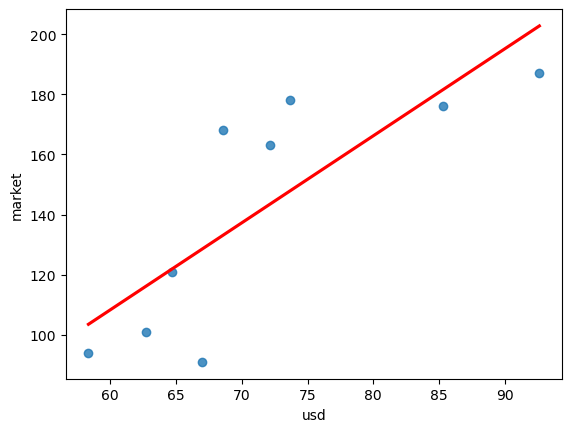

In [3]:
sns.regplot(data=df, x='usd', y='market', ci=None, line_kws={"color": "r"})

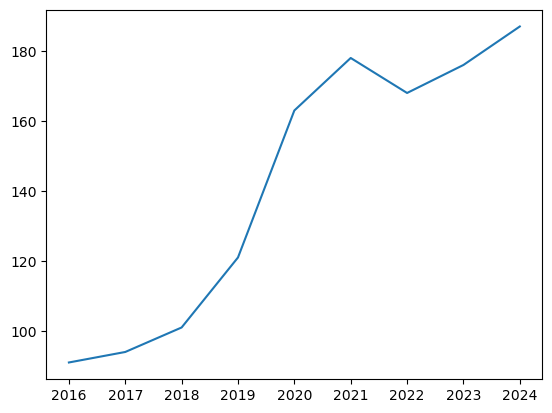

In [4]:
plt.plot(df['year'],df['market'])
plt.show()

In [5]:
fitted_line = smf.ols(formula='market~usd', data=df).fit()
fitted_line.params.round(2)

Intercept   -65.37
usd           2.89
dtype: float64

При увеличении курса доллара на 1 рубль, объём рынка видеоигр в России увеличивается примерно на 2,89 млрд руб.

In [6]:
fitted_line = smf.ols(formula='pc~usd', data=df).fit()
fitted_line.params.round(2)

Intercept    26.86
usd           0.71
dtype: float64

При увеличении курса доллара на 1 рубль, объём ПК-гейминга в России увеличивается примерно на 0,71 млрд руб.

In [7]:
fitted_line = smf.ols(formula='phone~usd', data=df).fit()
fitted_line.params.round(2)

Intercept   -11.49
usd           1.05
dtype: float64

При увеличении курса доллара на 1 рубль, объём рынка мобильного гейминга в России увеличивается примерно на 1,05 млрд руб.

In [8]:
fitted_line = smf.ols(formula='console~usd', data=df).fit()
fitted_line.params.round(2)

Intercept    28.99
usd          -0.17
dtype: float64

При увеличении курса доллара на 1 рубль, объём консольного гейминга в России уменьшается примерно на 0,17 млрд руб.

In [9]:
X = sm.add_constant(df['year'])  # добавим свободный член
y = df['market']
model_year = sm.OLS(y, X).fit()

In [10]:
future_years = pd.DataFrame({'year': list(range(2025, 2031))})
X_future = sm.add_constant(future_years)

In [11]:
future_years['forecast_year'] = model_year.predict(X_future)

In [12]:
print(future_years.round(0))

   year  forecast_year
0  2025          211.0
1  2026          224.0
2  2027          238.0
3  2028          252.0
4  2029          265.0
5  2030          279.0


In [13]:
Z = sm.add_constant(df['usd'])

In [14]:
model_usd = sm.OLS(y, Z).fit()

In [15]:
future_course = pd.DataFrame({'usd': [70, 80, 90, 100, 110, 130, 150]})
Z_future = sm.add_constant(future_course)

In [16]:
future_course['forecast_usd'] = model_usd.predict(Z_future)

In [17]:
print(future_course.round(0))

   usd  forecast_usd
0   70         137.0
1   80         166.0
2   90         195.0
3  100         224.0
4  110         253.0
5  130         311.0
6  150         369.0


In [18]:
forecaster = AutoARIMA(information_criterion='bic', test='kpss', seasonal=False)
forecaster.fit(y)
forecaster.get_fitted_params()

{'intercept': 25.811277236393728,
 'ar.L1': 1.4305493835089695,
 'ar.L2': -0.6099647443351557,
 'sigma2': 201.79195597226365,
 'order': (2, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 83.79500895604394,
 'aicc': 93.79500895604394,
 'bic': 84.58390726538882,
 'hqic': 82.0925690214571}

In [19]:
forecaster = ARIMA(order=(2,0,0), trend='n')
forecaster.fit(y)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -39.758
Date:                Sun, 15 Jun 2025   AIC                             85.515
Time:                        17:08:55   BIC                             86.107
Sample:                             0   HQIC                            84.239
                                  - 9                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4952      0.667      2.242      0.025       0.188       2.802
ar.L2         -0.5057      0.681     -0.743      0.457      -1.839       0.828
sigma2       234.2500    234.865      0.997      0.319    -226.076     694.576
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.90   Prob(JB):                         1.00
Heteroskedasticity (H):               3.96   Skew:                             0.06
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
fh = ForecastingHorizon(np.arange(1,7), freq ='Y')
y_pred_arima = forecaster.fit_predict(y=y, fh=fh)
y_pred_arima.round(0)

9     191.0
10    190.0
11    188.0
12    185.0
13    182.0
14    178.0
Name: market, dtype: float64

In [21]:
volatility = ARCH(mean='AR', lags=2, vol='GARCH', p=2, q=1, power=2)  
volatility.fit(y)
volatility.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 market   R-squared:                       0.823
Mean Model:                        AR   Adj. R-squared:                  0.734
Vol Model:                      GARCH   Log-Likelihood:               -19.3910
Distribution:                  Normal   AIC:                           52.7820
Method:            Maximum Likelihood   BIC:                           52.4034
                                        No. Observations:                    7
Date:                Sun, Jun 15 2025   Df Residuals:                        4
Time:                        17:08:56   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         34.8229      0.324    107.430      0.000 [ 34.188, 35.458]
market[1]      0.9677  2.333e-03    414.743      0.000 [  0.963,  0.972]
market[2]     -0.1203  3.995e-04   -301.160      0.000 [ -0.121, -0.120]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.3962e-05      0.253  2.532e-04      1.000      [ -0.495,  0.495]
alpha[1]   1.8468e-05  5.626e-04  3.283e-02      0.974 [-1.084e-03,1.121e-03]
alpha[2]       0.8713      0.134      6.506  7.725e-11      [  0.609,  1.134]
beta[1]    3.3266e-05  1.088e-04      0.306      0.760 [-1.800e-04,2.465e-04]
=============================================================================

Covariance estimator: robust
"""

In [22]:
fh = ForecastingHorizon(np.arange(1,7), freq ='Y')
y_pred_garch = volatility.fit_predict(y=y, fh=fh)
y_pred_garch.round(0)

9     195.0
10    201.0
11    206.0
12    210.0
13    213.0
14    216.0
Name: market, dtype: float64

In [23]:
pred_ints = forecaster.predict_interval(fh=fh, coverage=0.95)
print(pred_ints.columns.tolist())

[('market', 0.95, 'lower'), ('market', 0.95, 'upper')]


In [24]:
baseline = y_pred_arima
optimistic = pred_ints[('market', 0.95, 'upper')]
pessimistic = pred_ints[('market', 0.95, 'lower')]

In [26]:
optimistic.round(0)

9     221.0
10    244.0
11    263.0
12    278.0
13    290.0
14    300.0
Name: (market, 0.95, upper), dtype: float64

In [27]:
pessimistic.round(0)

9     161.0
10    136.0
11    113.0
12     92.0
13     73.0
14     56.0
Name: (market, 0.95, lower), dtype: float64

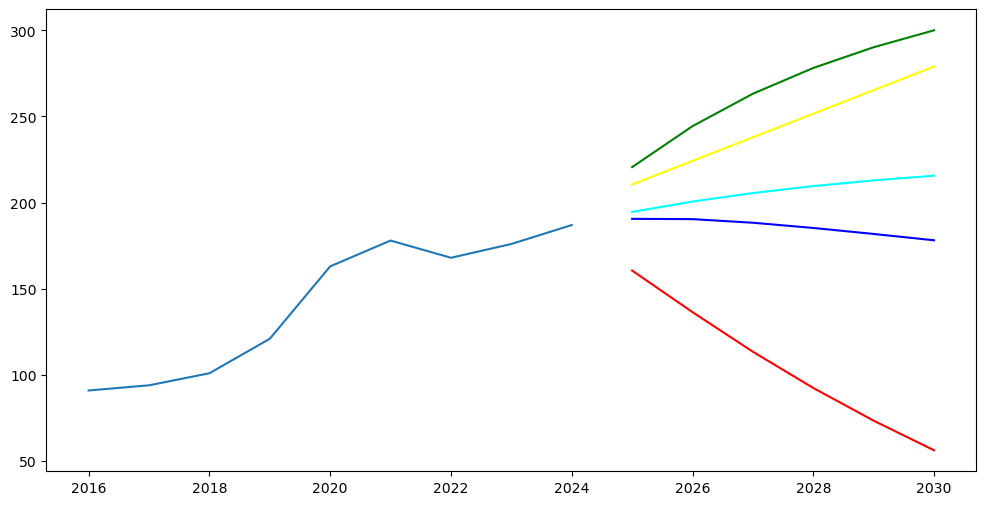

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['market'], label='Данные 2016-2024')
plt.plot(future_years['year'], future_years['forecast_year'], label='Линейный прогноз 2025-2030', color='yellow')
plt.plot(y_pred_arima.index+2016, baseline, label='Базовый прогноз ARIMA 2025-2030', color='blue')
plt.plot(y_pred_arima.index+2016, optimistic, label='Оптимистичный прогноз ARIMA 2025-2030', color='green')
plt.plot(y_pred_arima.index+2016, pessimistic, label='Пессимистичный прогноз ARIMA 2025-2030', color='red')
plt.plot(y_pred_garch.index+2016, y_pred_garch, label='Волатильность GARCH', color='cyan')

Прогноз на 2025-2030 гг

Жёлтый - Прогноз LinearRegression

Зелёный - Оптимистичный прогноз ARIMA 2025-2030

Синий - Базовый прогноз ARIMA 2025-2030

Красный - Пессимистичный прогноз ARIMA 2025-2030

Циан - Волатильность GARCH